# **Environmental predictors of bird species richness across the United States: a route-based spatial analysis**
A route-based analysis of bird species richness across the contiguous United States, using BBS routes as the observational units and environmental predictors summarized along each route.


## Research objectives

Quantify spatial variation in bird species richness across the contiguous United States using BBS routes.

Assess how NDVI and elevation predict species richness at the route level.

Evaluate spatial autocorrelation in species richness and model residuals.

Use geographicaly weighted regression for points.

In [1]:
# Libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import httpx
import requests
import matplotlib.pyplot as plt

### Study area

In [2]:
states_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip"
r = httpx.get(states_url, verify=False, timeout=None)
us_states = gpd.read_file(r.content, engine="pyogrio")

C:\Users\Matěj Tvarůžka\Documenty\Programming\R_statistics\GitHub\spatial-data-science-for-social-geography-Solitaris60w\.pixi\envs\default\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files. Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()
C:\Users\Matěj Tvarůžka\Documenty\Programming\R_statistics\GitHub\spatial-data-science-for-social-geography-Solitaris60w\.pixi\envs\default\Lib\site-packages\pyogrio\core.py:36: RuntimeWarning: Could not detect PROJ data files. Set PROJ_LIB environment variable to the correct path.
  _init_proj_data()


In [3]:
exclude = ['AK', 'HI', 'PR', 'VI', 'MP', 'GU', 'AS'] # States outside the area of interest
states = us_states.query("STUSPS not in @exclude") # Accesing the exclude variable outside the query() string
us_boundary = states.dissolve()

### BBS data

Now it's time to load the data about species richness, which consists for the number of species detected at the location.

In [4]:
bbs = gpd.read_file("bbs_routes_SR_2018.gpkg", engine = "fiona")
bbs = bbs.loc[bbs["CountryNum"] == 840] # Select only US transects
bbs = bbs.loc[bbs["StateNum"] != 3] # Select every state except Alaska
bbs.head()

,RTENO,RouteName,StateNum,Route,CountryNum,species_richness,geometry
0,84002001,ST FLORIAN,2,001,840,63,POINT (-87.60414 34.86869)
1,84002004,TRADE,2,004,840,51,POINT (-87.05924 34.02979)
2,84002007,SWAIM,2,007,840,63,POINT (-86.20304 34.86804)
3,84002008,PINE GROVE,2,008,840,66,POINT (-85.71104 34.02781)
4,84002010,MILLERVILLE,2,010,840,59,POINT (-85.92584 33.19135)


In [5]:
routes = gpd.read_file("stanford-routes-geojson.json")
routes.head()

Skipping field bbox: unsupported OGR type: 3


,id,fnode_,tnode_,lpoly_,rpoly_,length,bbsrtsl020,arc_length,rteno,rtename,rteleng,geometry
0,vy474dv5024.1,3,4,0,0,0.41414,1,39658.1,2072,ELKMONT,39658.1,"MULTILINESTRING ((-87.34746 34.94893, -87.3461..."
1,vy474dv5024.2,5,6,0,0,0.41892,2,39343.2,2001,ST FLORIAN,39343.2,"MULTILINESTRING ((-87.99044 34.905, -87.9879 3..."
2,vy474dv5024.3,7,12,0,0,0.44543,3,44896.5,2204,STEVENSON,44896.5,"MULTILINESTRING ((-85.77996 34.88146, -85.7794..."
3,vy474dv5024.4,13,1,0,0,0.40238,4,41350.3,2073,WOODVILLE,41350.3,"MULTILINESTRING ((-86.23356 34.72212, -86.2333..."
4,vy474dv5024.5,10,9,0,0,0.37732,5,37331.3,2071,WHEELER DAM,37331.3,"MULTILINESTRING ((-87.58241 34.74839, -87.5825..."


Unfortunately, the route geometries are often inacurrate and sometimes consists of many several fragments, which can cause problems.
Therefore we first need to get rid of potentially wrong route geometries. The expected route geometry ought to be about 40 km lengths, so let's filter potential outliers from this value.

In [6]:
routes = routes.to_crs(epsg=5070) # First set the crs to USA Contiguous Albers Equal Area Conic projection
routes['calc_length_km'] = routes.geometry.length / 1000 # Calculating the route length for given geometry

mask = (routes['calc_length_km'] >= 35) & (routes['calc_length_km'] <= 45) # Filter out fragments and over-long routes
routes_filtered = routes[mask].copy()

routes_final = routes_filtered.drop_duplicates(subset=['rteno']) # Remove duplicate 'rteno' rows 

print(f"Original routes count: {len(routes)}")
print(f"Filtered routes count (35-48km): {len(routes_final)}")
print(f"Average route length: {routes_final['calc_length_km'].mean():.2f} km")

Original routes count: 3731
Filtered routes count (35-48km): 2661
Average route length: 40.22 km


In [7]:
routes = routes_final[['rteno', 'rteleng', 'geometry']]
bbs = bbs.to_crs(routes.crs)
routes.crs.equals(bbs.crs)

True

To combine BBS data with routes geometries we use spatil join using "inner" as we need matching values in both tables.

In [8]:
bbs['geometry'] = bbs.buffer(400) # Add a small buffer (400 m) to points to account for GPS inaccuracy

joined_data = gpd.sjoin(routes, bbs, how='inner', predicate='intersects') # Spatial join of bbs points data with the routes geometries

print(f"Routes in subset: {len(routes)}")
print(f"Routes with data: {len(joined_data['rteno'].unique())}")

Routes in subset: 2661
Routes with data: 1659


In [9]:
joined_data.head()

,rteno,rteleng,geometry,index_right,RTENO,RouteName,StateNum,Route,CountryNum,species_richness
0,2072,39658.1,"MULTILINESTRING ((782641.086 1356740.039, 7827...",45,84002072,ELKMONT,2,072,840,63
2,2204,44896.5,"MULTILINESTRING ((924730.744 1363310.348, 9247...",59,84002204,STEVENSON,2,204,840,54
3,2073,41350.3,"MULTILINESTRING ((885664.635 1341263.847, 8856...",46,84002073,WOODVILLE,2,073,840,65
4,2071,37331.3,"MULTILINESTRING ((763430.539 1332485.496, 7634...",44,84002071,WHEELER DAM,2,071,840,61
5,2007,44022.0,"MULTILINESTRING ((868470.938 1344038.894, 8689...",2,84002007,SWAIM,2,007,840,63


In [10]:
bbs_routes = joined_data.drop(columns = ["RTENO", "CountryNum", "StateNum", "RouteName", "index_right", "Route"])

bbs_routes["buff_5000"] = bbs_routes.buffer(5000)  # Creating 5 km buffer

bbs_routes["route_midpoint"] = bbs_routes.geometry.interpolate(0.5, normalized=True) # Calculate the midpoint (50% along the line) for spatial weights

bbs_routes.head()

,rteno,rteleng,geometry,species_richness,buff_5000,route_midpoint
0,2072,39658.1,"MULTILINESTRING ((782641.086 1356740.039, 7827...",63,"POLYGON ((781444.31 1351282.844, 781080.681 13...",POINT (799058.572 1358112.819)
2,2204,44896.5,"MULTILINESTRING ((924730.744 1363310.348, 9247...",54,"POLYGON ((909651.978 1349408.223, 909642.34 13...",POINT (920348.379 1362929.766)
3,2073,41350.3,"MULTILINESTRING ((885664.635 1341263.847, 8856...",65,"POLYGON ((881582.169 1344150.743, 881920.966 1...",POINT (896739.468 1353510.85)
4,2071,37331.3,"MULTILINESTRING ((763430.539 1332485.496, 7634...",61,"POLYGON ((765146.155 1325367.953, 763912.471 1...",POINT (776778.912 1331128.439)
5,2007,44022.0,"MULTILINESTRING ((868470.938 1344038.894, 8689...",63,"POLYGON ((867783.618 1339092.383, 867517.304 1...",POINT (879587.923 1341112.567)


In [11]:
# If you need WGS84 (Lat/Lon) for external APIs:
temp_gdf = bbs_routes.set_geometry('route_midpoint').to_crs(4326)
bbs_routes['lon'] = temp_gdf.geometry.x
bbs_routes['lat'] = temp_gdf.geometry.y
bbs_routes = bbs_routes.set_geometry("buff_5000")
bbs_routes.head()

,rteno,rteleng,geometry,species_richness,buff_5000,route_midpoint,lon,lat
0,2072,39658.1,"MULTILINESTRING ((782641.086 1356740.039, 7827...",63,"POLYGON ((781444.31 1351282.844, 781080.681 13...",POINT (799058.572 1358112.819),-87.165585,34.947663
2,2204,44896.5,"MULTILINESTRING ((924730.744 1363310.348, 9247...",54,"POLYGON ((909651.978 1349408.223, 909642.34 13...",POINT (920348.379 1362929.766),-85.828469,34.882273
3,2073,41350.3,"MULTILINESTRING ((885664.635 1341263.847, 8856...",65,"POLYGON ((881582.169 1344150.743, 881920.966 1...",POINT (896739.468 1353510.85),-86.098286,34.820793
4,2071,37331.3,"MULTILINESTRING ((763430.539 1332485.496, 7634...",61,"POLYGON ((765146.155 1325367.953, 763912.471 1...",POINT (776778.912 1331128.439),-87.437364,34.725656
5,2007,44022.0,"MULTILINESTRING ((868470.938 1344038.894, 8689...",63,"POLYGON ((867783.618 1339092.383, 867517.304 1...",POINT (879587.923 1341112.567),-86.300269,34.726329


### NDVI raster

Normalized Difference Vegetation Index (NDVI) describes the health of vegetation within pixels of a raster image by measuring the amount of near-infrared (NIR) light being reflected by vegetation. Healthy vegetation reflects more NIR and less red relative to unhealthy vegetation or inorganic matter of the same visible color (such as turf fields), making it convenient for assessing the relative health of vegetation in a raster image compared to its surroundings.

NDVI is calculated for each pixel with the following calculation:

$\Large NDVI = \frac{(NIR - Red)}{(NIR + Red)}$

This formula generates a value between -1 and +1. Low reflectance in the red channel and high reflectance in the NIR channel will yield a high NDVI value (healthy vegetation), while the inverse will result in a low NDVI value (unhealthy vegetation). Negative values typically represent non-vegetation such as water or rock.


In [12]:
import datashader as ds
import geopandas as gpd
import rioxarray
import osmnx as ox
import xvec

For the NDVI data I decided to use Vegetation Index (1 month - Terra/MODIS) from NEO (Nasa Earth Observations) - https://neo.gsfc.nasa.gov/view.php?datasetId=MOD_NDVI_M&date=2018-06-01

In [13]:
ndvi = rioxarray.open_rasterio("MOD_NDVI_M_2018-06-01_rgb_3600x1800.TIFF")
ndvi

<xarray.DataArray (band: 1, y: 1800, x: 3600)> Size: 6MB
[6480000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.9 180.0
  * y            (y) float64 14kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    _FillValue:              0
    scale_factor:            1.0
    add_offset:              0.0

In [14]:
ndvi_us = ndvi.rio.clip(us_boundary.to_crs(ndvi.rio.crs).geometry)
ndvi_us

<xarray.DataArray (band: 1, y: 248, x: 577)> Size: 143kB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 248, 577), dtype=uint8)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 5kB -124.6 -124.5 -124.4 ... -67.25 -67.15 -67.05
  * y            (y) float64 2kB 49.35 49.25 49.15 49.05 ... 24.85 24.75 24.65
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0

In [15]:
ndvi_us = ndvi_us.drop_vars("band").squeeze() # Getting rid of redundant dimension
ndvi_us

<xarray.DataArray (y: 248, x: 577)> Size: 143kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(248, 577), dtype=uint8)
Coordinates:
  * x            (x) float64 5kB -124.6 -124.5 -124.4 ... -67.25 -67.15 -67.05
  * y            (y) float64 2kB 49.35 49.25 49.15 49.05 ... 24.85 24.75 24.65
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0

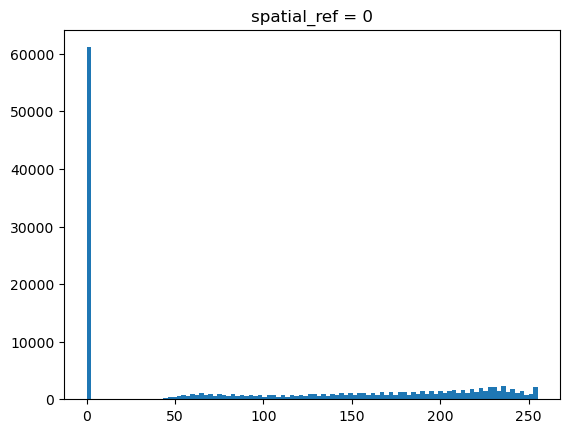

In [16]:
_ = ndvi_us.plot.hist(bins=100)

There are a lot of zeros, so I need to filter them out.

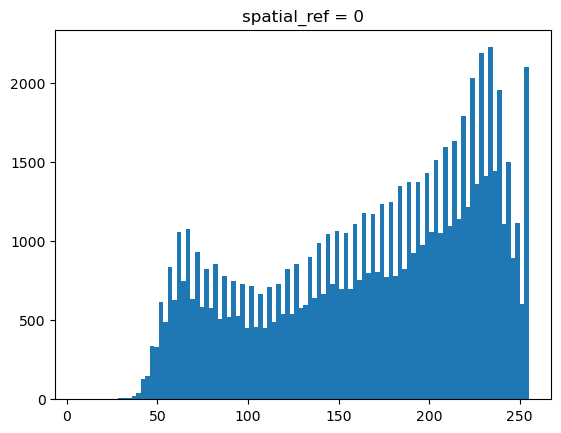

In [17]:
ndvi_us = ndvi_us.where(ndvi_us>0)
_ = ndvi_us.where(ndvi_us>0).plot.hist(bins=100)

In [18]:
ndvi_us

<xarray.DataArray (y: 248, x: 577)> Size: 572kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(248, 577), dtype=float32)
Coordinates:
  * x            (x) float64 5kB -124.6 -124.5 -124.4 ... -67.25 -67.15 -67.05
  * y            (y) float64 2kB 49.35 49.25 49.15 49.05 ... 24.85 24.75 24.65
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0

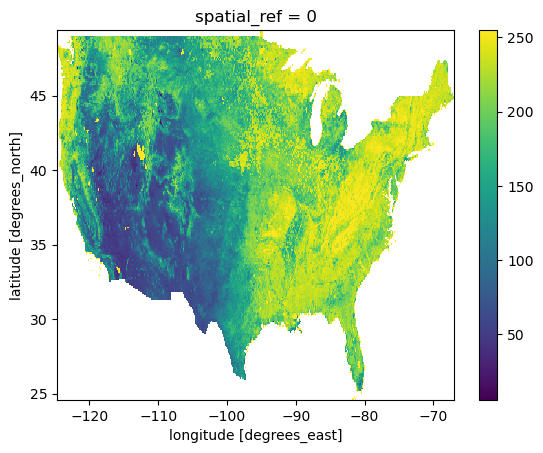

In [19]:
_ = ndvi_us.plot()

Now it is time to extract NDVI values for each transect using buffer of 5 km from routes geometry.

In [20]:
# Check the pixel size (width and height)
pixel_width, pixel_height = ndvi_us.rio.resolution()
print(f"Pixel resolution: {pixel_width} x {pixel_height}")

# Check the CRS to see if it's in degrees (4326) or meters
print(f"Raster CRS: {ndvi_us.rio.crs}")

Pixel resolution: 0.09999999999999999 x -0.09999999999999998
Raster CRS: EPSG:4326


In [21]:
ndvi_us = ndvi_us.rio.reproject(bbs_routes.crs)
print(f"New Resolution in meters: {ndvi_us.rio.transform()[0]}")

New Resolution in meters: 9007.395170646003


In [22]:
ndvi_extraction = bbs_routes.set_geometry("buff_5000").to_crs(ndvi_us.rio.crs)

zonal_stats = ndvi_us.drop_vars("spatial_ref").xvec.zonal_stats(
    geometry=ndvi_extraction.buff_5000,
    x_coords="x",
    y_coords="y",
    stats=["mean", "std"],
)
zonal_stats

<xarray.DataArray (geometry: 1668, zonal_statistics: 2)> Size: 27kB
array([[224.6000061 ,  11.35957813],
       [238.5       ,  11.72959232],
       [252.        ,   2.82842708],
       ...,
       [129.75      ,   9.09326649],
       [164.5       ,  30.56005096],
       [131.57142639,  17.32757568]], shape=(1668, 2))
Coordinates:
  * zonal_statistics  (zonal_statistics) <U4 32B 'mean' 'std'
  * geometry          (geometry) geometry 13kB POLYGON ((781444.3095840941 13...
    index             (geometry) int64 13kB 0 2 3 4 5 ... 3726 3728 3729 3730
Indexes:
    geometry  GeometryIndex (crs=EPSG:5070)
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0.0

In [23]:
ndvi = zonal_stats.xvec.to_geodataframe(name="NDVI")
ndvi.head()

,geometry,index,NDVI
zonal_statistics,,,
mean,"POLYGON ((781444.31 1351282.844, 781080.681 13...",0,224.600006
std,"POLYGON ((781444.31 1351282.844, 781080.681 13...",0,11.359578
mean,"POLYGON ((909651.978 1349408.223, 909642.34 13...",2,238.500000
std,"POLYGON ((909651.978 1349408.223, 909642.34 13...",2,11.729592
mean,"POLYGON ((881582.169 1344150.743, 881920.966 1...",3,252.000000


In [24]:
# Returns the count of NaNs for every column in the dataframe
print(ndvi.isna().sum())

geometry     0
index        0
NDVI        24
dtype: int64


In [25]:
# Drop rows where the NDVI value is missing
ndvi_clean = ndvi.dropna(subset=['NDVI'])

# Check how many rows were removed
print(f"Rows before: {len(ndvi)}")
print(f"Rows after: {len(ndvi_clean)}")

Rows before: 3336
Rows after: 3312


In [26]:
ndvi_clean.head()

,geometry,index,NDVI
zonal_statistics,,,
mean,"POLYGON ((781444.31 1351282.844, 781080.681 13...",0,224.600006
std,"POLYGON ((781444.31 1351282.844, 781080.681 13...",0,11.359578
mean,"POLYGON ((909651.978 1349408.223, 909642.34 13...",2,238.500000
std,"POLYGON ((909651.978 1349408.223, 909642.34 13...",2,11.729592
mean,"POLYGON ((881582.169 1344150.743, 881920.966 1...",3,252.000000


In [27]:
# This creates a table with index as rows and mean/std/min/max as columns
ndvi_stats = ndvi_clean.reset_index().pivot(
    index='index', 
    columns='zonal_statistics', 
    values='NDVI'
)

# Add the 'ndvi_' prefix to the new columns
ndvi_stats.columns = ['ndvi_' + col for col in ndvi_stats.columns]

# Get the unique geometries for each index
geometries = ndvi_clean[['index', 'geometry']].drop_duplicates('index').set_index('index')

# Join them together
ndvi_data = geometries.join(ndvi_stats).reset_index()

ndvi_data.head()

,index,geometry,ndvi_mean,ndvi_std
0,0,"POLYGON ((781444.31 1351282.844, 781080.681 13...",224.600006,11.359578
1,2,"POLYGON ((909651.978 1349408.223, 909642.34 13...",238.500000,11.729592
2,3,"POLYGON ((881582.169 1344150.743, 881920.966 1...",252.000000,2.828427
3,4,"POLYGON ((765146.155 1325367.953, 763912.471 1...",200.750000,3.418699
4,5,"POLYGON ((867783.618 1339092.383, 867517.304 1...",238.833328,18.261223


<Axes: ylabel='Frequency'>

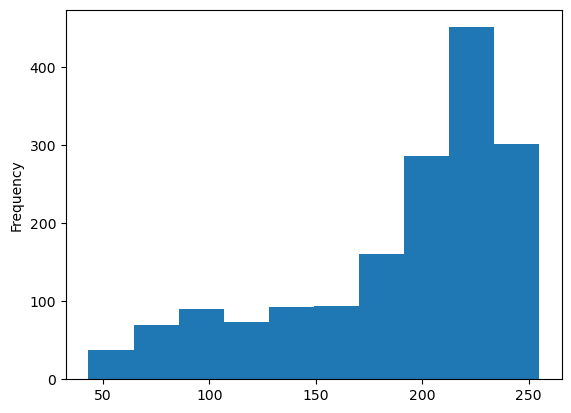

In [28]:
ndvi_data["ndvi_mean"].plot.hist()

Now it's time to standardize the NDVI values.

In [29]:
# Standardize the Mean (Relative Productivity)
# (Value - average of all routes) / standard deviation of all routes
ndvi_data['ndvi_mean_z'] = (ndvi_data['ndvi_mean'] - ndvi_data['ndvi_mean'].mean()) / ndvi_data['ndvi_mean'].std()

# Standardize the Std (Relative Heterogeneity)
# We treat the 'std' as its own variable and standardize IT.
ndvi_data['ndvi_heterog_z'] = (ndvi_data['ndvi_std'] - ndvi_data['ndvi_std'].mean()) / ndvi_data['ndvi_std'].std()

In [30]:
ndvi_data.head()

,index,geometry,ndvi_mean,ndvi_std,ndvi_mean_z,ndvi_heterog_z
0,0,"POLYGON ((781444.31 1351282.844, 781080.681 13...",224.600006,11.359578,0.672306,-0.018898
1,2,"POLYGON ((909651.978 1349408.223, 909642.34 13...",238.500000,11.729592,0.936933,0.023228
2,3,"POLYGON ((881582.169 1344150.743, 881920.966 1...",252.000000,2.828427,1.193944,-0.990175
3,4,"POLYGON ((765146.155 1325367.953, 763912.471 1...",200.750000,3.418699,0.218252,-0.922973
4,5,"POLYGON ((867783.618 1339092.383, 867517.304 1...",238.833328,18.261223,0.943279,0.766859


In [31]:
ndvi_to_join = ndvi_data[['ndvi_mean_z', 'ndvi_heterog_z', 'geometry']]

buffer = bbs_routes.set_geometry('buff_5000')

# Perform the Spatial Join
# 'predicate=inner' ensures the polygons must overlap/be the same
# 'how=inner' keeps only rows that exist in both sets
bbs_ndvi = gpd.sjoin(
    buffer, 
    ndvi_to_join, 
    how='inner', 
    predicate='intersects'
)

# sjoin adds an 'index_right' column we usually don't need
if 'index_right' in bbs_ndvi.columns:
    bbs_ndvi = bbs_ndvi.drop(columns='index_right')

data = bbs_ndvi.drop_duplicates(subset=['rteno'])

data.head()

,rteno,rteleng,geometry,species_richness,buff_5000,route_midpoint,lon,lat,ndvi_mean_z,ndvi_heterog_z
0,2072,39658.1,"MULTILINESTRING ((782641.086 1356740.039, 7827...",63,"POLYGON ((781444.31 1351282.844, 781080.681 13...",POINT (799058.572 1358112.819),-87.165585,34.947663,0.672306,-0.018898
2,2204,44896.5,"MULTILINESTRING ((924730.744 1363310.348, 9247...",54,"POLYGON ((909651.978 1349408.223, 909642.34 13...",POINT (920348.379 1362929.766),-85.828469,34.882273,0.936933,0.023228
3,2073,41350.3,"MULTILINESTRING ((885664.635 1341263.847, 8856...",65,"POLYGON ((881582.169 1344150.743, 881920.966 1...",POINT (896739.468 1353510.85),-86.098286,34.820793,0.943279,0.766859
4,2071,37331.3,"MULTILINESTRING ((763430.539 1332485.496, 7634...",61,"POLYGON ((765146.155 1325367.953, 763912.471 1...",POINT (776778.912 1331128.439),-87.437364,34.725656,0.218252,-0.922973
5,2007,44022.0,"MULTILINESTRING ((868470.938 1344038.894, 8689...",63,"POLYGON ((867783.618 1339092.383, 867517.304 1...",POINT (879587.923 1341112.567),-86.300269,34.726329,0.943279,0.766859


In [32]:
# 'RdYlGn' (Red-Yellow-Green) is the gold standard for NDVI
# vmin/vmax -2.5 to 2.5 ensures the 'Yellow' is exactly at the mean (0)
m = data.explore(
    column='ndvi_mean_z', 
    cmap='RdYlGn', 
    vmin=-2.5, 
    vmax=2.5, 
    legend=True,
    tooltip=['ndvi_mean_z'], # Hover to see raw vs z-score
    tiles="CartoDB positron",
    popup=True # Click to see all data for that route
)
# m

From the map we can see, that there is a potential for pseudoreplication, when in some regions, there are lots of overlapping buffers, which can result in the same NDVI values. To deal with that, we need to exclude overlappig buffers.

In [33]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1659 entries, 0 to 3730
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   rteno             1659 non-null   int32   
 1   rteleng           1659 non-null   float64 
 2   geometry          1659 non-null   geometry
 3   species_richness  1659 non-null   int64   
 4   buff_5000         1659 non-null   geometry
 5   route_midpoint    1659 non-null   geometry
 6   lon               1659 non-null   float64 
 7   lat               1659 non-null   float64 
 8   ndvi_mean_z       1659 non-null   float64 
 9   ndvi_heterog_z    1659 non-null   float64 
dtypes: float64(5), geometry(3), int32(1), int64(1)
memory usage: 136.1 KB


In [34]:
data.geometry

0       POLYGON ((781444.31 1351282.844, 781080.681 13...
2       POLYGON ((909651.978 1349408.223, 909642.34 13...
3       POLYGON ((881582.169 1344150.743, 881920.966 1...
4       POLYGON ((765146.155 1325367.953, 763912.471 1...
5       POLYGON ((867783.618 1339092.383, 867517.304 1...
                              ...                        
3723    POLYGON ((-1156185.604 2106078.224, -1156023.8...
3726    POLYGON ((-992094.742 2064698.408, -992094.965...
3728    POLYGON ((-689859.774 2029759.044, -689870.007...
3729    POLYGON ((-948471.423 2060173.098, -948404.643...
3730    POLYGON ((-800908.751 2039414.443, -800843.408...
Name: buff_5000, Length: 1659, dtype: geometry

In [35]:
def thin_spatial_geopandas(data, distance_threshold=1):
    # 1. Ensure we are working with a copy and shuffle for randomness
    gdf_temp = data.copy().sample(frac=1).reset_index(drop=True)
    
    keep_indices = []
    discard_indices = []
    processed = np.zeros(len(gdf_temp), dtype=bool)

    # 2. Build a spatial index
    sindex = gdf_temp.sindex

    for i in range(len(gdf_temp)):
        if processed[i]:
            continue
        
        # Keep this route
        keep_indices.append(i)
        processed[i] = True
        
        # Find all neighbors within the distance threshold
        current_geom = gdf_temp.geometry.iloc[i]
        # query returns indices of geometries whose bounding box intersects the search area
        # Then we filter by actual distance
        potential_neighbors = sindex.query(current_geom.buffer(distance_threshold))
        
        for neighbor_idx in potential_neighbors:
            if not processed[neighbor_idx] and neighbor_idx != i:
                # Double check actual distance (since query uses bounding boxes)
                if current_geom.distance(gdf_temp.geometry.iloc[neighbor_idx]) < distance_threshold:
                    discard_indices.append(neighbor_idx)
                    processed[neighbor_idx] = True
                    
    return gdf_temp.iloc[keep_indices], gdf_temp.iloc[discard_indices]

# Run the thinning (make sure your CRS is in meters, e.g., EPSG:5070)
df_thinned, df_removed = thin_spatial_geopandas(data, distance_threshold=1)

print(f"Routes kept: {len(df_thinned)}")
print(f"Routes removed: {len(df_removed)}")

Routes kept: 1387
Routes removed: 272


In [36]:
import folium
# 1. Plot the 'Kept' routes first
m = df_thinned.explore(
    color='green', 
    marker_kwds={'radius': 5, 'fill': True},
    name="Kept Routes",
    tooltip=['species_richness', 'ndvi_mean_z', 'ndvi_heterog_z'], # Check data on hover
    tiles="CartoDB positron"
)

# 2. Add the 'Removed' routes as a second layer
df_removed.explore(
    m=m, # This tells it to use the same map object
    color='red', 
    marker_kwds={'radius': 3, 'fill': True},
    name="Removed (Overlapping)",
    tooltip=['species_richness', 'ndvi_mean_z', 'ndvi_heterog_z'],
    style_kwds={'opacity': 0.3, 'fillOpacity': 0.2} # Make them faint
)
folium.LayerControl(collapsed=False).add_to(m)
# m

In [37]:
df_thinned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1387 entries, 0 to 1658
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   rteno             1387 non-null   int32   
 1   rteleng           1387 non-null   float64 
 2   geometry          1387 non-null   geometry
 3   species_richness  1387 non-null   int64   
 4   buff_5000         1387 non-null   geometry
 5   route_midpoint    1387 non-null   geometry
 6   lon               1387 non-null   float64 
 7   lat               1387 non-null   float64 
 8   ndvi_mean_z       1387 non-null   float64 
 9   ndvi_heterog_z    1387 non-null   float64 
dtypes: float64(5), geometry(3), int32(1), int64(1)
memory usage: 113.8 KB


In [38]:
bbs_ndvi = df_thinned

### Elevation data

In [39]:
bbs_ndvi.head()

,rteno,rteleng,geometry,species_richness,buff_5000,route_midpoint,lon,lat,ndvi_mean_z,ndvi_heterog_z
0,72903,38859.9,"MULTILINESTRING ((1699576.373 2163780.132, 169...",58,"POLYGON ((1702691.735 2167905.984, 1702957.158...",POINT (1696461.808 2176857.42),-75.525745,40.950086,0.803667,-0.116762
1,72069,38596.0,"MULTILINESTRING ((1537021.326 2115347.535, 153...",67,"POLYGON ((1533502.575 2118893.475, 1533530.411...",POINT (1551398.792 2126396.728),-77.347574,40.773776,0.832224,-1.312194
2,89055,42406.1,"MULTILINESTRING ((-1858961.608 2937534.943, -1...",53,"POLYGON ((-1860659.893 2947323.857, -1860658.2...",POINT (-1853686.87 2943648.132),-120.650811,47.309076,0.132581,1.989844
3,27024,39845.4,"MULTILINESTRING ((1159164.687 1296015.856, 115...",56,"POLYGON ((1148194.56 1322675.341, 1148165.2 13...",POINT (1158926.521 1310945.987),-83.296379,34.164567,0.770351,-0.656316
4,54006,40041.9,"MULTILINESTRING ((-223740.81 1959402.077, -223...",43,"POLYGON ((-228736.272 1959669.059, -228736.047...",POINT (-206224.383 1961402.565),-98.459203,40.640529,0.843647,-0.568757


In [42]:
import ee
import geemap

# 1. Initialize Earth Engine with your Project ID
# project_id = 'your-project-id-here' # Replace with your actual ID from GEE

try:
    ee.Initialize(project="my-project-ee-470714")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="my-project-ee-470714")

# 2. Convert your DataFrame rows into GEE Features
# We use 'rteno' as a unique ID to merge back later
features = []
for index, row in bbs_ndvi.iterrows():
    # GEE uses [Longitude, Latitude]
    point = ee.Geometry.Point([row['lon'], row['lat']])
    feat = ee.Feature(point, {'rteno': row['rteno']})
    features.append(feat)

points_ee = ee.FeatureCollection(features)

# 3. Load the NASADEM Global 30m dataset
# 'elevation' is the specific band name in this dataset
nasadem = ee.Image("NASA/NASADEM_HGT/001").select('elevation')

# 4. Sample the image at your points
# scale=30 matches the native pixel size of the NASA data
sampled_points = nasadem.sampleRegions(
    collection=points_ee,
    properties=['rteno'],
    scale=30
)

# 5. Convert back to a Pandas DataFrame
df_elev = geemap.ee_to_df(sampled_points)
# 6. Merge the elevation back to your original thinned dataframe
data_final = bbs_ndvi.merge(df_elev[['rteno', 'elevation']], on='rteno', how='left')


print("Elevation successfully extracted from GEE!")
print(data_final[['rteno', 'elevation']].head())

Elevation successfully extracted from GEE!
   rteno  elevation
0  72903        304
1  72069        399
2  89055       1081
3  27024        225
4  54006        604


In [43]:
data_final.head()

,rteno,rteleng,geometry,species_richness,buff_5000,route_midpoint,lon,lat,ndvi_mean_z,ndvi_heterog_z,elevation
0,72903,38859.9,"MULTILINESTRING ((1699576.373 2163780.132, 169...",58,"POLYGON ((1702691.735 2167905.984, 1702957.158...",POINT (1696461.808 2176857.42),-75.525745,40.950086,0.803667,-0.116762,304
1,72069,38596.0,"MULTILINESTRING ((1537021.326 2115347.535, 153...",67,"POLYGON ((1533502.575 2118893.475, 1533530.411...",POINT (1551398.792 2126396.728),-77.347574,40.773776,0.832224,-1.312194,399
2,89055,42406.1,"MULTILINESTRING ((-1858961.608 2937534.943, -1...",53,"POLYGON ((-1860659.893 2947323.857, -1860658.2...",POINT (-1853686.87 2943648.132),-120.650811,47.309076,0.132581,1.989844,1081
3,27024,39845.4,"MULTILINESTRING ((1159164.687 1296015.856, 115...",56,"POLYGON ((1148194.56 1322675.341, 1148165.2 13...",POINT (1158926.521 1310945.987),-83.296379,34.164567,0.770351,-0.656316,225
4,54006,40041.9,"MULTILINESTRING ((-223740.81 1959402.077, -223...",43,"POLYGON ((-228736.272 1959669.059, -228736.047...",POINT (-206224.383 1961402.565),-98.459203,40.640529,0.843647,-0.568757,604


In [44]:
# Save to a GeoPackage
# Pass the column names as a list
data_export = data_final.drop(columns=["geometry", "buff_5000"])
data_export.to_file("Assignement_data.gpkg", layer='bbs_routes', driver="GPKG")

In [45]:
data = gpd.read_file("Assignement_data.gpkg")
data.head()

,rteno,rteleng,species_richness,lon,lat,ndvi_mean_z,ndvi_heterog_z,elevation,geometry
0,72903,38859.9,58,-75.525745,40.950086,0.803667,-0.116762,304,POINT (1696461.808 2176857.42)
1,72069,38596.0,67,-77.347574,40.773776,0.832224,-1.312194,399,POINT (1551398.792 2126396.728)
2,89055,42406.1,53,-120.650811,47.309076,0.132581,1.989844,1081,POINT (-1853686.87 2943648.132)
3,27024,39845.4,56,-83.296379,34.164567,0.770351,-0.656316,225,POINT (1158926.521 1310945.987)
4,54006,40041.9,43,-98.459203,40.640529,0.843647,-0.568757,604,POINT (-206224.383 1961402.565)


In [46]:
data["elevation"].describe()

count    1387.000000
mean      617.507570
std       662.768655
min        -1.000000
25%       167.000000
50%       333.000000
75%       895.000000
max      3275.000000
Name: elevation, dtype: float64

In [49]:
# 1. Plot the 'Kept' routes first
m = data.explore(
    column="elevation",
    color='blue', 
    marker_kwds={'radius': 5, 'fill': True},
    name="Kept Routes",
    tooltip=["elevation"], # Check data on hover
    tiles="CartoDB positron"
)
m

In [50]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1387 entries, 0 to 1386
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   rteno             1387 non-null   int32   
 1   rteleng           1387 non-null   float64 
 2   species_richness  1387 non-null   int64   
 3   lon               1387 non-null   float64 
 4   lat               1387 non-null   float64 
 5   ndvi_mean_z       1387 non-null   float64 
 6   ndvi_heterog_z    1387 non-null   float64 
 7   elevation         1387 non-null   int64   
 8   geometry          1387 non-null   geometry
dtypes: float64(5), geometry(1), int32(1), int64(2)
memory usage: 92.2 KB
